In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
from scipy.optimize import nnls

insitu1 = pd.read_excel("/Users/emma/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Thesis/data/MS_In_situ_Vannmiljo_lakes_coastals.xlsx")
insitu = pd.read_csv("/Users/emma/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Thesis/data/model/VT16_imputed_plus_syntheticTEST.csv")

# parameters
lam0 = 443
a_water_lam0 = 0.0064
bb_water_lam0 = 0.0035

In [27]:
chosen_station = "VT16"

# clean and prepare in-situ data
insitu1 = insitu1.rename(columns={
    "Prøvetakingstidspunkt": "date",
    "s": "Station"
})

insitu1["date"] = pd.to_datetime(insitu1["date"]).dt.date
insitu["date"] = pd.to_datetime(insitu["date"]).dt.date

# stations
insitu1 = insitu1[insitu1["Station"] == chosen_station]
insitu = insitu[insitu["Station"] == chosen_station]

# Keep only needed columns
insitu = insitu[["date", "SECCI", "CDOM", "KLFA", "TSM", "Station","is_interpolated"]].dropna()
insitu = insitu.rename(columns={
    "CDOM": "CDOM_insitu",
    "KLFA": "KLFA_insitu",
    "TSM": "TSM_insitu"
})

# Remove any duplicate rows after merging
insitu = insitu.drop_duplicates()


In [28]:
# k_d from secchi PAR: do it now for 443nm (lambda of choice here) 
insitu_df = insitu[["date", "SECCI"]].copy()
insitu_df = insitu_df.dropna(subset=["SECCI"])
insitu["k_d_insitu"] = 1.7 / insitu_df["SECCI"]

k_d_array = insitu["k_d_insitu"]
k_d_insitu = insitu["k_d_insitu"].mean()
print(k_d_insitu)

# REAL k_d from secchi PAR: do it now for 443nm (lambda of choice here) 
insitu_df1 = insitu1[["date", "SECCI"]].copy()
insitu_df1 = insitu_df1.dropna(subset=["SECCI"])
insitu1["k_d_insitu"] = 1.7 / insitu_df1["SECCI"]

print(insitu1["k_d_insitu"].mean())

0.1711457408112906
0.18456454869128


In [29]:
def to_1d(x):
    return np.asarray(x, dtype=float).reshape(-1)

def estimate_astar_stable_PAR(
    kd_measured,
    CDOM, CHL, TSM,
    a_water,
    lam=0.001
):
    """
    Estimate a*_CDOM, a*_PHY, a*_NAP from Kd(PAR)
    using NNLS + Tikhonov regularization
    """

    alpha = 0.002   # scaling CDOM
    beta = 1

    # Left-hand side: observed minus known terms
    bb_p = alpha * (TSM ** beta)
    bb_total = bb_p + bb_water_lam0
    b = kd_measured - a_water
    print("bb_total mean:", bb_total.mean())
    print("bb_p mean:", bb_p.mean())
    print("b mean:", b.mean())

    # Design matrix
    A = np.column_stack([CDOM, CHL, TSM])

    # Regularization
    sqrt_lam = np.sqrt(lam)
    A_aug = np.vstack([A, sqrt_lam * np.eye(3)])
    b_aug = np.concatenate([b, np.zeros(3)])

    # NNLS
    astar, _ = nnls(A_aug, b_aug)

    kd_predicted = (A @ astar) + a_water

    return {
        "a_star_CDOM": astar[0],
        "a_star_PHY":  astar[1],
        "a_star_NAP":  astar[2],
        "kd_predicted": kd_predicted
    }


# application of the model
results = estimate_astar_stable_PAR(
    kd_measured = k_d_array,
    CDOM = insitu["CDOM_insitu"],
    CHL  = insitu["KLFA_insitu"],
    TSM  = insitu["TSM_insitu"],
    a_water = a_water_lam0,
    lam = 0.00000001
)

a_cdom_star = results["a_star_CDOM"]
a_ph_star = results["a_star_PHY"]
a_nap_star = results["a_star_NAP"]
kd_predicted = results["kd_predicted"]

# compared to litterature here variation in time there in space so not exact match is logical
print("Estimated a*_CDOM:", a_cdom_star)
print("Estimated a*_PHY:", a_ph_star)
print("Estimated a*_NAP:", a_nap_star)
print("Predicted Kd (mean):", kd_predicted.mean())

# correlations between insitu parameters
CDOM = insitu["CDOM_insitu"]
CHL  = insitu["KLFA_insitu"]
TSM  = insitu["TSM_insitu"]

print("corr(CDOM, TSM) =", np.corrcoef(CDOM, TSM)[0,1])
print("corr(CHL,  TSM) =", np.corrcoef(CHL,  TSM)[0,1])
print("corr(CDOM, CHL) =", np.corrcoef(CDOM, CHL)[0,1])

bb_total mean: 0.004728434327316347
bb_p mean: 0.0012284343273163462
b mean: 0.16474574081129062
Estimated a*_CDOM: 0.6970336426078293
Estimated a*_PHY: 0.013612659828720073
Estimated a*_NAP: 0.01022525179109923
Predicted Kd (mean): 0.16996605053899205
corr(CDOM, TSM) = 0.22106156317010256
corr(CHL,  TSM) = 0.1910035155463976
corr(CDOM, CHL) = 0.4123304292100497


In [30]:
# assuming that the effect of each of the OACs on total absorption coefficient is linearly additive
# IN SITU ////
cdom_ins = insitu["CDOM_insitu"].values
chl_ins = insitu["KLFA_insitu"].values
tsm_ins = insitu["TSM_insitu"].values

# IOP calculations
a_cdom_ins = a_cdom_star * cdom_ins
a_ph_ins = a_ph_star * chl_ins
a_nap_ins = a_nap_star * tsm_ins

atot_ins = (a_water_lam0* 0.8) + a_cdom_ins + a_ph_ins + a_nap_ins

# backscatter
alpha = 0.02    # choose within 0.007–0.03 depending on your water type
beta  = 1    # usually between 0.7 and 1.1
bb_p = alpha * (tsm_ins ** beta)
bb_ins = bb_p + bb_water_lam0 

X_ins = np.column_stack([a_cdom_ins, a_ph_ins, a_nap_ins, bb_ins])
y_ins = insitu["k_d_insitu"].values

In [31]:
# from sklearn.metrics import mean_squared_error, r2_score
# from scipy.stats import linregress
# import numpy as np
# import matplotlib.pyplot as plt

# Kd_pred = atot_ins + bb_ins

# # Metrics
# rmse = np.sqrt(mean_squared_error(k_d_array, Kd_pred))
# r2 = r2_score(k_d_array, Kd_pred)

# print(f"RMSE = {rmse:.4f}")
# print(f"R2   = {r2:.4f}")

# # Linear regression: Predicted vs Observed
# slope, intercept, r_value, p_value, std_err = linregress(k_d_array, Kd_pred)

# # Regression line
# x_line = np.linspace(k_d_array.min(), k_d_array.max(), 100)
# y_line = slope * x_line + intercept

# plt.figure(figsize=(6,6))
# plt.scatter(k_d_array, Kd_pred, alpha=0.7, label="Samples")

# # 1:1 line
# plt.plot(
#     x_line, x_line,
#     'r--', label="1:1 Line"
# )

# # Regression line
# plt.plot(
#     x_line, y_line,
#     'k-', linewidth=2,
#     label=f"Fit: y = {slope:.2f}x + {intercept:.2f}\nR = {r_value:.2f}"
# )

# plt.xlabel("Observed Kd (1/m)")
# plt.ylabel("Predicted Kd (1/m)")
# plt.title("Pure Physics-Based Kd Model")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Print regression parameters
# print(f"Slope: {slope:.4f}")
# print(f"Intercept: {intercept:.4f}")


RMSE: mean=0.0382, 2.5%=0.0296, 97.5%=0.0488
R2:   mean=0.5710, 2.5%=0.3007, 97.5%=0.7297
a_CDOM: mean=1.0588e+00, 95% CI=[9.3876e-01, 1.1552e+00]
a_PHY: mean=7.5102e-01, 95% CI=[3.1022e-01, 1.2449e+00]
a_NAP: mean=1.5092e-01, 95% CI=[-1.0479e-02, 3.7919e-01]
b_b: mean=4.2609e-01, 95% CI=[5.1367e-02, 9.4665e-01]


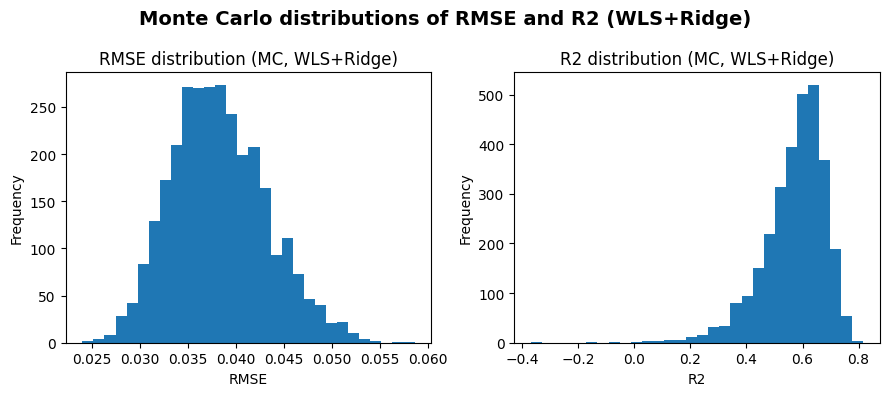

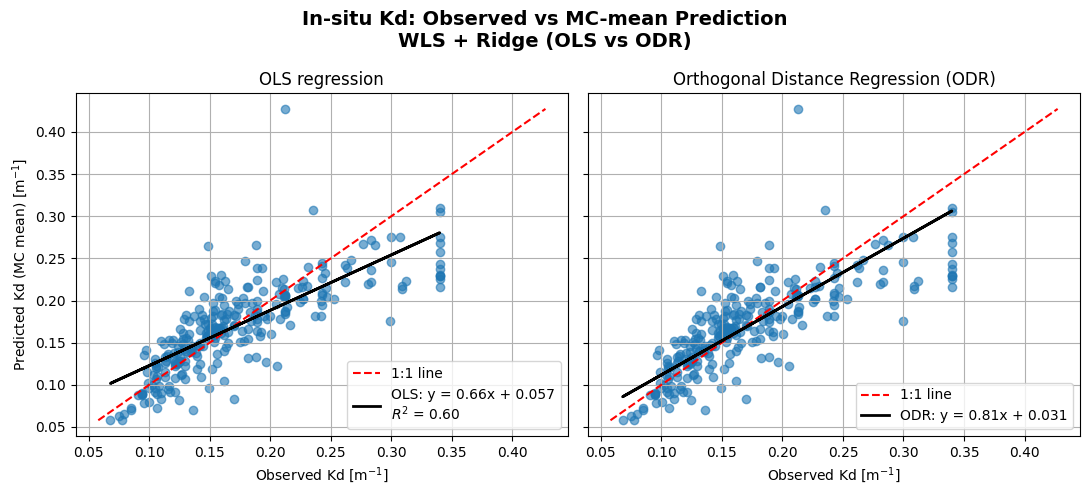

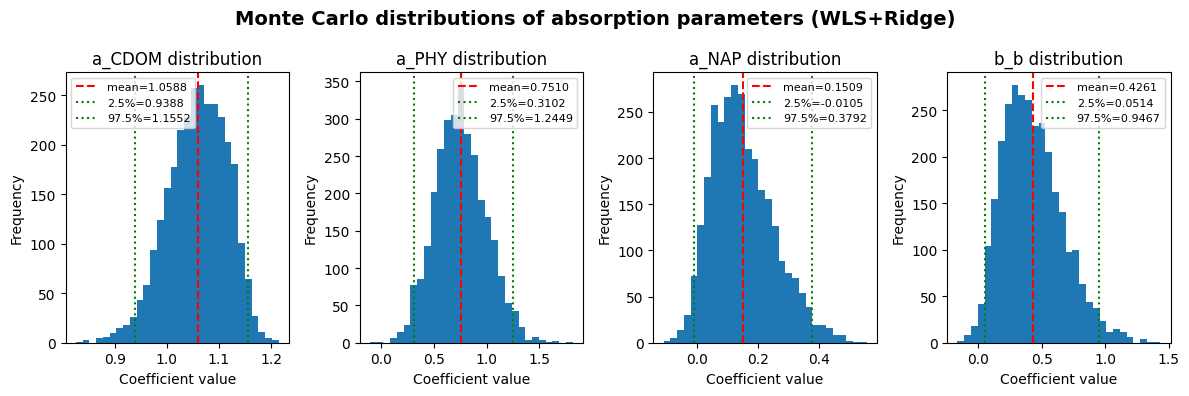

In [32]:
def wls_ridge(A, y, sigma=None, lam=0.01):
    """
    Weighted Least Squares with Ridge regularization

    Minimize:
        ||W (Ax - y)||^2 + lam ||x||^2

    Parameters
    ----------
    A : (n, p) array
    y : (n,) array
    sigma : (n,) array or None
        Standard deviation of y (weights = 1/sigma^2)
    lam : float
        Ridge regularization strength
    """

    n, p = A.shape

    if sigma is None:
        W = np.eye(n)
    else:
        W = np.diag(1.0 / sigma**2)

    AtW = A.T @ W
    lhs = AtW @ A + lam * np.eye(p)
    rhs = AtW @ y

    coef = np.linalg.solve(lhs, rhs)
    return coef

# ---------------- MONTE CARLO ---------------- #

n_iter = 3000
test_size = 0.3
random_seed = 42
lam = 0.01              # ridge strength (tune if needed)

np.random.seed(random_seed)

rmse_list = []
r2_list = []
coeffs = []

# Optional: observation uncertainty on Kd (or use None)
sigma_y = None   # e.g. 0.05 * y_ins if relative error

for i in range(n_iter):

    # ---- Bootstrap sampling ----
    idx = np.arange(X_ins.shape[0])
    boot_idx = resample(
        idx,
        replace=True,
        n_samples=len(idx),
        random_state=random_seed + i
    )

    X_boot = X_ins[boot_idx]
    y_boot = y_ins[boot_idx]

    # ---- Train / validation split ----
    n_val = max(1, int(np.round(test_size * len(boot_idx))))

    rng = np.random.RandomState(random_seed + i)
    perm = rng.permutation(len(boot_idx))
    val_idx = perm[:n_val]
    train_idx = perm[n_val:]

    X_train = X_boot[train_idx]
    y_train = y_boot[train_idx]
    X_val   = X_boot[val_idx]
    y_val   = y_boot[val_idx]

    # ---- WLS + Ridge fit
    coef = wls_ridge(
        A=X_train,
        y=y_train,
        sigma=None,     # or sigma_y[train_idx]
        lam=lam
    )

    coeffs.append(coef)

    # ---- Validation prediction ----
    y_pred_val = X_val @ coef

    rmse_list.append(
        np.sqrt(mean_squared_error(y_val, y_pred_val))
    )

    r2_list.append(
        r2_score(y_val, y_pred_val) if len(y_val) > 1 else np.nan
    )

rmse_arr = np.array(rmse_list)
r2_arr   = np.array(r2_list)
coeffs_arr = np.vstack(coeffs)

print(
    "RMSE: mean={:.4f}, 2.5%={:.4f}, 97.5%={:.4f}".format(
        rmse_arr.mean(),
        np.nanpercentile(rmse_arr, 2.5),
        np.nanpercentile(rmse_arr, 97.5)
    )
)

print(
    "R2:   mean={:.4f}, 2.5%={:.4f}, 97.5%={:.4f}".format(
        np.nanmean(r2_arr),
        np.nanpercentile(r2_arr, 2.5),
        np.nanpercentile(r2_arr, 97.5)
    )
)

feature_names = ["a_CDOM", "a_PHY", "a_NAP", "b_b"]

for j, name in enumerate(feature_names):
    coef_mean = coeffs_arr[:, j].mean()
    low, high = np.percentile(coeffs_arr[:, j], [2.5, 97.5])
    print(
        f"{name}: mean={coef_mean:.4e}, "
        f"95% CI=[{low:.4e}, {high:.4e}]"
    )

plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.hist(rmse_arr, bins=30)
plt.title("RMSE distribution (MC, WLS+Ridge)")
plt.xlabel("RMSE")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(r2_arr, bins=30)
plt.title("R2 distribution (MC, WLS+Ridge)")
plt.xlabel("R2")
plt.ylabel("Frequency")

plt.suptitle("Monte Carlo distributions of RMSE and R2 (WLS+Ridge)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Kd_ins_pred_mean = np.mean(coeffs_arr @ X_ins.T, axis=0)

from scipy.odr import ODR, Model, Data

# ==============================
# REGRESSION DIAGNOSTICS
# ==============================

# ---- OLS regression ----
slope_ols, intercept_ols = np.polyfit(y_ins, Kd_ins_pred_mean, 1)
y_fit_ols = slope_ols * y_ins + intercept_ols
r2_ols = np.corrcoef(y_ins, Kd_ins_pred_mean)[0, 1]**2

# ---- ODR regression ----
def linear_model(B, x):
    return B[0] * x + B[1]

model = Model(linear_model)
data = Data(y_ins, Kd_ins_pred_mean)
odr = ODR(data, model, beta0=[1.0, 0.0])
out = odr.run()

slope_odr, intercept_odr = out.beta
y_fit_odr = slope_odr * y_ins + intercept_odr

# ==============================
# PLOT: OLS vs ODR (SIDE BY SIDE)
# ==============================

lims = [
    min(y_ins.min(), Kd_ins_pred_mean.min()),
    max(y_ins.max(), Kd_ins_pred_mean.max())
]

fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharex=True, sharey=True)

# ---- LEFT: OLS ----
axes[0].scatter(y_ins, Kd_ins_pred_mean, alpha=0.6)
axes[0].plot(lims, lims, "r--", label="1:1 line")
axes[0].plot(
    y_ins,
    y_fit_ols,
    color="black",
    linewidth=2,
    label=(
        f"OLS: y = {slope_ols:.2f}x + {intercept_ols:.3f}\n"
        f"$R^2$ = {r2_ols:.2f}"
    )
)
axes[0].set_title("OLS regression")
axes[0].set_xlabel("Observed Kd [m$^{-1}$]")
axes[0].set_ylabel("Predicted Kd (MC mean) [m$^{-1}$]")
axes[0].grid(True)
axes[0].legend()

# ---- RIGHT: ODR ----
axes[1].scatter(y_ins, Kd_ins_pred_mean, alpha=0.6)
axes[1].plot(lims, lims, "r--", label="1:1 line")
axes[1].plot(
    y_ins,
    y_fit_odr,
    color="black",
    linewidth=2,
    label=(
        f"ODR: y = {slope_odr:.2f}x + {intercept_odr:.3f}"
    )
)
axes[1].set_title("Orthogonal Distance Regression (ODR)")
axes[1].set_xlabel("Observed Kd [m$^{-1}$]")
axes[1].grid(True)
axes[1].legend()

fig.suptitle(
    "In-situ Kd: Observed vs MC-mean Prediction\nWLS + Ridge (OLS vs ODR)",
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout()
plt.show()

# PLOT: Distribution of absorption parameters
plt.figure(figsize=(12, 4))

for j, name in enumerate(feature_names):
    plt.subplot(1, len(feature_names), j+1)
    plt.hist(coeffs_arr[:, j], bins=30)
    plt.title(f"{name} distribution")
    plt.xlabel("Coefficient value")
    plt.ylabel("Frequency")
    mean_val = coeffs_arr[:, j].mean()
    low, high = np.percentile(coeffs_arr[:, j], [2.5, 97.5])
    # Mark mean and 95% CI
    plt.axvline(mean_val, color='red', linestyle='--', label=f"mean={mean_val:.4f}")
    plt.axvline(low, color='green', linestyle=':', label=f"2.5%={low:.4f}")
    plt.axvline(high, color='green', linestyle=':', label=f"97.5%={high:.4f}")
    plt.legend(fontsize=8)

plt.suptitle("Monte Carlo distributions of absorption parameters (WLS+Ridge)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()
